In [1]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'  # default is ‘last_expr’

%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append('/repos/wildlife-conservation-society.orinoquia-land-use')

In [3]:
import os
import json
from collections import defaultdict

import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np

from geospatial.visualization.raster_label_visualizer import RasterLabelVisualizer

# Combine WCS categories into coarser categories

2020 June 29 - Combined the WCS categories into coarser categories.

In [4]:
# legend for the labels, with the corresponding WCS classes appended as a column manually
legend_path = '/MSOneDrive/AI4Earth/LandUse/WCS Colombia/classes_list/LULC_legend_w_WCS_classes.xlsx'
original_legend = pd.read_excel(legend_path)

In [5]:
len(original_legend)
original_legend

50

,Raster_val,LULC_spanish,LULC_english,Class_WCS,Class_WCS_202004,Class_WCS_coarse
0,1,1.1.1. Tejido urbano continuo,Continuous urban network,Urban,Urban,Urban and infrastructure
1,2,1.1.2. Tejido urbano discontinuo,Discontinuous urban network,Urban,Urban,Urban and infrastructure
2,3,1.2.1. Zonas industriales o comerciales,Industrial or comercial zones,Urban,Urban,Urban and infrastructure
3,4,"1.2.2. Red vial, ferroviaria y terrenos asociados","Roads, rails and associated terrains",Infrastructure,Infrastructure,Urban and infrastructure
4,5,1.2.4. Aeropuertos,Airports,Infrastructure,Infrastructure,Urban and infrastructure
5,6,1.3.1. Zonas de extraccion minera,Mining zones,Mining,Mining,Urban and infrastructure
6,7,1.4.2. Instalaciones recreativas,Recreation zones,Urban,Urban,Urban and infrastructure
7,8,2.1.1. Otros cultivos transitorios,Other temporary crops,Other temporary crops,Other temporary crops,Agriculture
8,9,2.1.2. Cereales,Cereals,Other temporary crops,Other temporary crops,Agriculture
9,10,2.1.4. Hortalizas,Vegetables,Other temporary crops,Other temporary crops,Agriculture


In [6]:
fine_to_coarse_class = {}
coarse_name_to_num = {}
coarse_i = 1

for i_row, row in original_legend.iterrows():
    fine_to_coarse_class[row['Class_WCS_202004']] = row['Class_WCS_coarse']
    
    if row['Class_WCS_coarse'] not in coarse_name_to_num:
        coarse_name_to_num[row['Class_WCS_coarse']] = coarse_i
        coarse_i += 1

In [7]:
fine_to_coarse_class

{'Urban': 'Urban and infrastructure',
 'Infrastructure': 'Urban and infrastructure',
 'Mining': 'Urban and infrastructure',
 'Other temporary crops': 'Agriculture',
 'Permanent herbaceous crops': 'Agriculture',
 'Other permanent shrubby crops': 'Agriculture',
 'Other permanent arboreal crops': 'Arboreal and forestry crops',
 'Intensive livestock': 'Pasture',
 'Silvopastoral livestock': 'Pasture',
 'Secondary herbaceous vegetation': 'Vegetation',
 'Other agricultural areas': 'Agriculture',
 'Dense forest': 'Forest',
 'Open forest': 'Forest',
 'Fragmented forest': 'Forest',
 'Gallery forest': 'Forest',
 'Forestry crops': 'Arboreal and forestry crops',
 'Savanna': 'Savanna',
 'Shrubland': 'Vegetation',
 'Secondary shrubby/arboreal vegetation': 'Vegetation',
 'Sandy areas': 'Sand, rocks and bare land',
 'Rocks': 'Sand, rocks and bare land',
 'Degraded and bare land': 'Sand, rocks and bare land',
 'Burnt zones': 'Unavailable',
 'Glaciers and snow zones': 'Unavailable',
 'Swamp': 'Swamp',
 '

In [8]:
fine_to_coarse_class['Empty of data'] = 'Empty of data'

In [9]:
coarse_name_to_num['Empty of data'] = 0

In [10]:
coarse_name_to_num

{'Urban and infrastructure': 1,
 'Agriculture': 2,
 'Arboreal and forestry crops': 3,
 'Pasture': 4,
 'Vegetation': 5,
 'Forest': 6,
 'Savanna': 7,
 'Sand, rocks and bare land': 8,
 'Unavailable': 9,
 'Swamp': 10,
 'Water': 11,
 'Seasonal savanna': 12,
 'Seasonally flooded savanna': 13,
 'Empty of data': 0}

In [11]:
coarse_num_to_name = {str(v): k for k, v in coarse_name_to_num.items()}

In [12]:
coarse_num_to_name

{'1': 'Urban and infrastructure',
 '2': 'Agriculture',
 '3': 'Arboreal and forestry crops',
 '4': 'Pasture',
 '5': 'Vegetation',
 '6': 'Forest',
 '7': 'Savanna',
 '8': 'Sand, rocks and bare land',
 '9': 'Unavailable',
 '10': 'Swamp',
 '11': 'Water',
 '12': 'Seasonal savanna',
 '13': 'Seasonally flooded savanna',
 '0': 'Empty of data'}

In [13]:
coarse_num_to_color = {
    '0': 'black',
    '1': 'lightgray',
    '2': 'pink',
    '3': 'teal',
    '4': 'salmon',
    '5': 'goldenrod',
    '6': 'darkseagreen',
    '7': 'gold',
    '8': 'blanchedalmond',
    '9': 'whitesmoke',
    '10': 'darkolivegreen',
    '11': 'deepskyblue',
    '12': 'khaki',
    '13': 'thistle'
}

In [14]:
label_maps = {
    'wcs_num_to_name': coarse_num_to_name,
    'wcs_name_to_num': coarse_name_to_num,
    'wcs_num_to_color': coarse_num_to_color
}

In [15]:
os.getcwd()

'/Users/siyuyang/Source/Repos/VSTS_AI4Good/wildlife-conservation-society.orinoquia-land-use/data'

In [16]:
with open('../constants/class_lists/wcs_fine_coarse_label_maps.json', 'w') as f:
    json.dump(label_maps, f, indent=4)

## Re-make the masks with the combined classes

In [19]:
with open('../constants/class_lists/lulc_wcs_label_maps.json') as f:
    fine_class_map = json.load(f)

In [20]:
fine_to_coarse_class_num = {}

for fine_class, coarse_class in fine_to_coarse_class.items():
    fine_to_coarse_class_num[fine_class_map['wcs_name_to_num'][fine_class]] = coarse_name_to_num[coarse_class]

In [21]:
fine_to_coarse_class_num

{1: 1,
 2: 1,
 3: 1,
 4: 2,
 5: 2,
 6: 2,
 7: 3,
 8: 4,
 9: 4,
 10: 5,
 11: 2,
 12: 6,
 13: 6,
 14: 6,
 15: 6,
 16: 3,
 17: 7,
 18: 5,
 19: 5,
 20: 8,
 21: 8,
 22: 8,
 23: 9,
 24: 9,
 25: 10,
 26: 11,
 27: 11,
 28: 11,
 29: 9,
 30: 2,
 31: 3,
 32: 12,
 33: 13,
 0: 0}

In [52]:
masks_dir = '/data/WCS_land_use/train_full_region_median/tiles_masks'
coarse_masks_dir = '/data/WCS_land_use/train_full_region_median/tiles_masks_coarse'

In [53]:
%%time

# this runs fairly fast

for fn in os.listdir(masks_dir):
    path = os.path.join(masks_dir, fn)
    mask_array = np.array(Image.open(path))
    for fine_class, coarse_class in fine_to_coarse_class_num.items():
        if fine_class == coarse_class:
            continue
            
        mask_array[mask_array == fine_class] = coarse_class
    
    mapped_im = Image.fromarray(mask_array)
    mapped_im.save(os.path.join(coarse_masks_dir, fn))

CPU times: user 22.6 s, sys: 6.73 s, total: 29.4 s
Wall time: 34.3 s


In [23]:
viz_utils = RasterLabelVisualizer('../constants/class_lists/wcs_coarse_label_map.json')

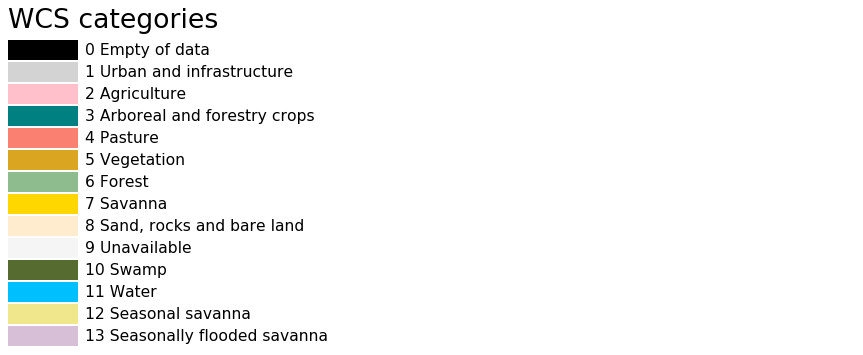

In [24]:
legend = viz_utils.plot_color_legend(legend_title='WCS categories')

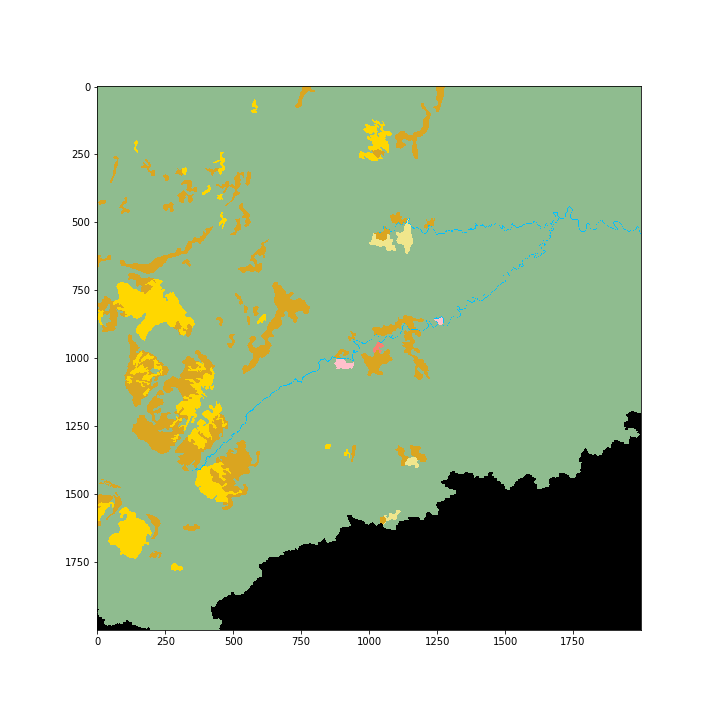

In [45]:
sample_tile_mask = Image.open('/data/WCS_land_use/train_full_region_median/tiles_masks_coarse/mask_-71.347_2.053.png')

im, buf = viz_utils.show_label_raster(sample_tile_mask)

im